##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tuning a BERT model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/docs/nlp/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/docs/nlp/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/docs/nlp/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial demonstrates how to fine-tune a [Bidirectional Encoder Representations from Transformers (BERT)](https://arxiv.org/abs/1810.04805) (Devlin et al., 2018) model using [TensorFlow Model Garden](https://github.com/tensorflow/models).

You can also find the pre-trained BERT model used in this tutorial on [TensorFlow Hub (TF Hub)](https://tensorflow.org/hub). For concrete examples of how to use the models from TF Hub, refer to the [Solve Glue tasks using BERT](https://www.tensorflow.org/text/tutorials/bert_glue) tutorial. If you're just trying to fine-tune a model, the TF Hub tutorial is a good starting point.

On the other hand, if you're interested in deeper customization, follow this tutorial. It shows how to do a lot of things manually, so you can learn how you can customize the workflow from data preprocessing to training, exporting and saving the model.

## Setup

### Install pip packages

Start by installing the TensorFlow Text and Model Garden pip packages.

*  `tf-models-official` is the TensorFlow Model Garden package. Note that it may not include the latest changes in the `tensorflow_models` GitHub repo. To include the latest changes, you may install `tf-models-nightly`, which is the nightly Model Garden package created daily automatically.
*  pip will install all models and dependencies automatically.

In [2]:
!pip install -q opencv-python

In [3]:
!pip install -q -U "tensorflow-text==2.9.*"

In [4]:
!pip install -q tf-models-official

### Import libraries

In [5]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

2022-12-16 12:10:57.079461: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-16 12:10:57.079587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-16 12:10:57.079596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### Resources

The following directory contains the BERT model's configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [6]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

## Load and preprocess the dataset

This example uses the GLUE (General Language Understanding Evaluation) MRPC (Microsoft Research Paraphrase Corpus) [dataset from TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc).

This dataset is not set up such that it can be directly fed into the BERT model. The following section handles the necessary preprocessing.

### Get the dataset from TensorFlow Datasets

The GLUE MRPC (Dolan and Brockett, 2005) dataset is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent. It has the following attributes:

*   Number of labels: 2
*   Size of training dataset: 3668
*   Size of evaluation dataset: 408
*   Maximum sequence length of training and evaluation dataset: 128

Begin by loading the MRPC dataset from TFDS:

In [7]:
batch_size=32
glue, info = tfds.load('glue/mrpc',
                       with_info=True,
                       batch_size=32)

In [8]:
glue

{'train': <PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 'validation': <PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 'test': <PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>}

The `info` object describes the dataset and its features:

In [9]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

The two classes are:

In [10]:
info.features['label'].names

['not_equivalent', 'equivalent']

Here is one example from the training set:

In [11]:
example_batch = next(iter(glue['train']))

for key, value in example_batch.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


2022-12-16 12:11:04.095203: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Preprocess the data

The keys `"sentence1"` and `"sentence2"` in the GLUE MRPC dataset contain two input sentences for each example.

Because the BERT model from the Model Garden doesn't take raw text as input, two things need to happen first:

1. The text needs to be _tokenized_ (split into word pieces) and converted to _indices_.
2. Then, the _indices_ need to be packed into the format that the model expects.

#### The BERT tokenizer

To fine tune a pre-trained language model from the Model Garden, such as BERT, you need to make sure that you're using exactly the same tokenization, vocabulary, and index mapping as used during training.

The following code rebuilds the tokenizer that was used by the base model using the Model Garden's `tfm.nlp.layers.FastWordpieceBertTokenizer` layer:

In [12]:
tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
    lower_case=True)

Let's tokenize a test sentence:

In [13]:
tokens = tokenizer(tf.constant(["Hello TensorFlow!"]))
tokens

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>

Learn more about the tokenization process in the [Subword tokenization](https://www.tensorflow.org/text/guide/subwords_tokenizer) and [Tokenizing with TensorFlow Text](https://www.tensorflow.org/text/guide/tokenizers) guides.

#### Pack the inputs

TensorFlow Model Garden's BERT model doesn't just take the tokenized strings as input. It also expects these to be packed into a particular format. `tfm.nlp.layers.BertPackInputs` layer can handle the conversion from _a list of tokenized sentences_ to the input format expected by the Model Garden's BERT model.

`tfm.nlp.layers.BertPackInputs` packs the two input sentences (per example in the MRCP dataset) concatenated together. This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token.

Therefore, the `tfm.nlp.layers.BertPackInputs` layer's constructor takes the `tokenizer`'s special tokens as an argument. It also needs to know the indices of the tokenizer's special tokens.

In [14]:
special = tokenizer.get_special_tokens_dict()
special

{'vocab_size': 30522,
 'start_of_sequence_id': 101,
 'end_of_segment_id': 102,
 'padding_id': 0,
 'mask_id': 103}

In [15]:
max_seq_length = 128

packer = tfm.nlp.layers.BertPackInputs(
    seq_length=max_seq_length,
    special_tokens_dict = tokenizer.get_special_tokens_dict())

The `packer` takes a list of tokenized sentences as input. For example:

In [16]:
sentences1 = ["hello tensorflow"]
tok1 = tokenizer(sentences1)
tok1

<tf.RaggedTensor [[[7592], [23435, 12314]]]>

In [17]:
sentences2 = ["goodbye tensorflow"]
tok2 = tokenizer(sentences2)
tok2

<tf.RaggedTensor [[[9119], [23435, 12314]]]>

Then, it returns a dictionary containing three outputs:

- `input_word_ids`: The tokenized sentences packed together.
- `input_mask`: The mask indicating which locations are valid in the other outputs.
- `input_type_ids`: Indicating which sentence each token belongs to.

In [18]:
packed = packer([tok1, tok2])

for key, tensor in packed.items():
  print(f"{key:15s}: {tensor[:, :12]}")

input_word_ids : [[  101  7592 23435 12314   102  9119 23435 12314   102     0     0     0]]
input_mask     : [[1 1 1 1 1 1 1 1 1 0 0 0]]
input_type_ids : [[0 0 0 0 0 1 1 1 1 0 0 0]]


#### Put it all together

Combine these two parts into a `keras.layers.Layer` that can be attached to your model:

In [19]:
class BertInputProcessor(tf.keras.layers.Layer):
  def __init__(self, tokenizer, packer):
    super().__init__()
    self.tokenizer = tokenizer
    self.packer = packer

  def call(self, inputs):
    tok1 = self.tokenizer(inputs['sentence1'])
    tok2 = self.tokenizer(inputs['sentence2'])

    packed = self.packer([tok1, tok2])

    if 'label' in inputs:
      return packed, inputs['label']
    else:
      return packed

But for now just apply it to the dataset using `Dataset.map`, since the dataset you loaded from TFDS is a `tf.data.Dataset` object:

In [20]:
bert_inputs_processor = BertInputProcessor(tokenizer, packer)

In [21]:
glue_train = glue['train'].map(bert_inputs_processor).prefetch(1)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Here is an example batch from the processed dataset:

In [22]:
example_inputs, example_labels = next(iter(glue_train))

2022-12-16 12:11:09.991776: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [23]:
example_inputs

{'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[ 101, 1996, 7235, ...,    0,    0,    0],
        [ 101, 2625, 2084, ...,    0,    0,    0],
        [ 101, 6804, 1011, ...,    0,    0,    0],
        ...,
        [ 101, 2021, 2049, ...,    0,    0,    0],
        [ 101, 2274, 2062, ...,    0,    0,    0],
        [ 101, 2043, 1037, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}

In [24]:
example_labels

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1])>

In [25]:
for key, value in example_inputs.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'{"labels":15s} shape: {example_labels.shape}')

input_word_ids  shape: (32, 128)
input_mask      shape: (32, 128)
input_type_ids  shape: (32, 128)
labels          shape: (32,)


The `input_word_ids` contain the token IDs:

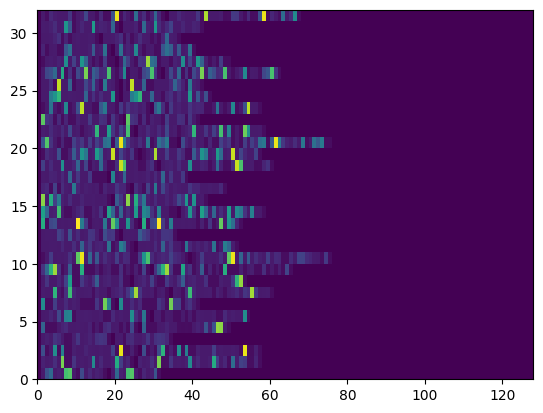

In [26]:
plt.pcolormesh(example_inputs['input_word_ids'])

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

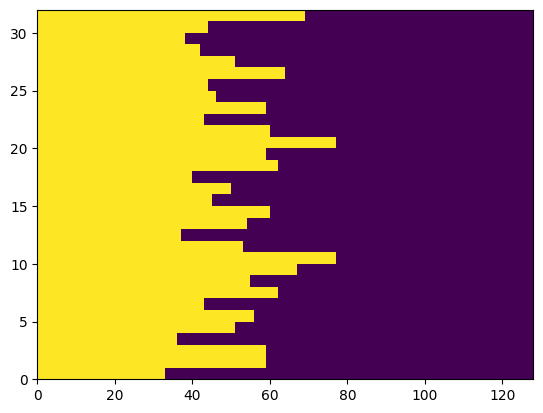

In [27]:
plt.pcolormesh(example_inputs['input_mask'])

The "input type" also has the same shape, but inside the non-padded region, contains a `0` or a `1` indicating which sentence the token is a part of.

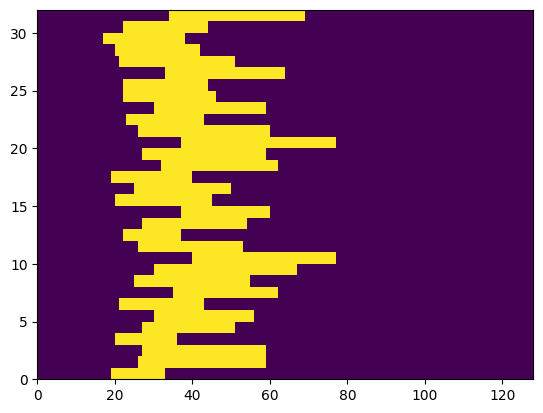

In [28]:
plt.pcolormesh(example_inputs['input_type_ids'])

Apply the same preprocessing to the validation and test subsets of the GLUE MRPC dataset:

In [29]:
glue_validation = glue['validation'].map(bert_inputs_processor).prefetch(1)
glue_test = glue['test'].map(bert_inputs_processor).prefetch(1)

## Build, train and export the model

Now that you have formatted the data as expected, you can start working on building and training the model.

### Build the model


The first step is to download the configuration file—`config_dict`—for the pre-trained BERT model:


In [30]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [31]:
encoder_config = tfm.nlp.encoders.EncoderConfig({
    'type':'bert',
    'bert': config_dict
})

In [32]:
bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)
bert_encoder

The configuration file defines the core BERT model from the Model Garden, which is a Keras model that predicts the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

In [33]:
bert_classifier = tfm.nlp.models.BertClassifier(network=bert_encoder, num_classes=2)

Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

In [34]:
bert_classifier(
    example_inputs, training=True).numpy()[:10]

array([[ 0.27796572,  0.3633405 ],
       [ 0.69361466,  0.14025433],
       [ 0.21482432,  0.90812004],
       [ 0.21482229, -0.33566046],
       [ 0.7247843 ,  1.0185758 ],
       [ 0.39823115, -0.04688799],
       [-0.36101037,  0.3939724 ],
       [-0.2397871 ,  0.22729942],
       [ 0.7429978 ,  0.45017534],
       [ 0.08199499,  0.20476133]], dtype=float32)

The `TransformerEncoder` in the center of the classifier above **is** the `bert_encoder`.

If you inspect the encoder, notice the stack of `Transformer` layers connected to those same three inputs:

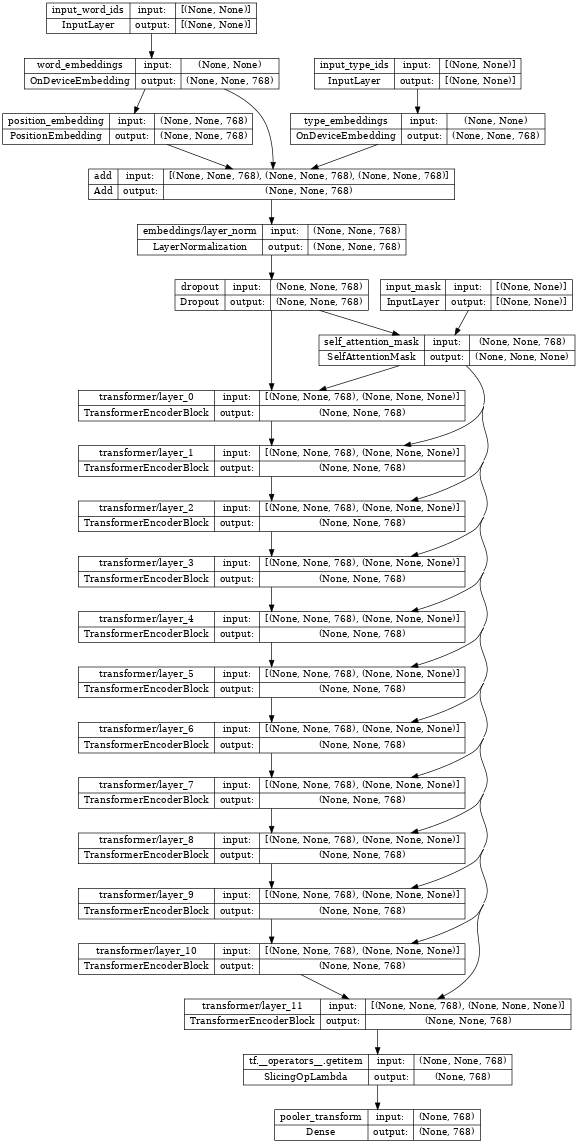

In [35]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restore the encoder weights

When built, the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [36]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Note: The pretrained `TransformerEncoder` is also available on [TensorFlow Hub](https://tensorflow.org/hub). Go to the [TF Hub appendix](#hub_bert) for details.

### Set up the optimizer

BERT typically uses the Adam optimizer with weight decay—[AdamW](https://arxiv.org/abs/1711.05101) (`tf.keras.optimizers.experimental.AdamW`).
It also employs a learning rate schedule that first warms up from 0 and then decays to 0:

In [37]:
# Set up epochs and steps
epochs = 5
batch_size = 32
eval_batch_size = 32

train_data_size = info.splits['train'].num_examples
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

Linear decay from `initial_learning_rate` to zero over `num_train_steps`.

In [38]:
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

Warmup to that value over `warmup_steps`:

In [39]:
warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

The overall schedule looks like this:

Text(0, 0.5, 'Learning rate')

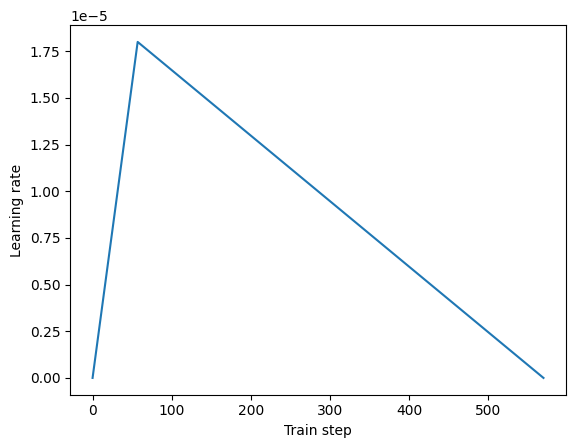

In [40]:
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')

Use `tf.keras.optimizers.experimental.AdamW` to instantiate the optimizer with that schedule:

In [41]:
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

### Train the model

Set the metric as accuracy and the loss as sparse categorical cross-entropy. Then, compile and train the BERT classifier:

In [42]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

In [43]:
bert_classifier.evaluate(glue_validation)

 1/13 [=>............................] - ETA: 37s - loss: 0.5569 - accuracy: 0.7500

 2/13 [===>..........................] - ETA: 1s - loss: 0.6044 - accuracy: 0.7031 

 3/13 [=====>........................] - ETA: 1s - loss: 0.6103 - accuracy: 0.6979

 4/13 [========>.....................] - ETA: 1s - loss: 0.5812 - accuracy: 0.7266

 5/13 [==========>...................] - ETA: 1s - loss: 0.5842 - accuracy: 0.7250

 6/13 [============>.................] - ETA: 1s - loss: 0.6072 - accuracy: 0.7031

 7/13 [===============>..............] - ETA: 0s - loss: 0.6095 - accuracy: 0.7009

 8/13 [=================>............] - ETA: 0s - loss: 0.6117 - accuracy: 0.6992

 9/13 [===================>..........] - ETA: 0s - loss: 0.6308 - accuracy: 0.6806

10/13 [======================>.......] - ETA: 0s - loss: 0.6302 - accuracy: 0.6812

11/13 [========================>.....] - ETA: 0s - loss: 0.6273 - accuracy: 0.6847

12/13 [==========================>...] - ETA: 0s - loss: 0.6327 - accuracy: 0.6797

13/13 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.6838

13/13 [==============================] - 5s 154ms/step - loss: 0.6285 - accuracy: 0.6838


[0.6284795999526978, 0.6838235259056091]

In [44]:
bert_classifier.fit(
      glue_train,
      validation_data=(glue_validation),
      batch_size=32,
      epochs=epochs)

Epoch 1/5


  1/115 [..............................] - ETA: 1:04:10 - loss: 0.6760 - accuracy: 0.6875

  2/115 [..............................] - ETA: 52s - loss: 0.5812 - accuracy: 0.7344    

  3/115 [..............................] - ETA: 52s - loss: 0.6261 - accuracy: 0.6875

  4/115 [>.............................] - ETA: 51s - loss: 0.6392 - accuracy: 0.6719

  5/115 [>.............................] - ETA: 51s - loss: 0.6718 - accuracy: 0.6313

  6/115 [>.............................] - ETA: 50s - loss: 0.6832 - accuracy: 0.6302

  7/115 [>.............................] - ETA: 50s - loss: 0.6744 - accuracy: 0.6384

  8/115 [=>............................] - ETA: 49s - loss: 0.6948 - accuracy: 0.6250

  9/115 [=>............................] - ETA: 49s - loss: 0.6955 - accuracy: 0.6250

 10/115 [=>............................] - ETA: 48s - loss: 0.7027 - accuracy: 0.6250

 11/115 [=>............................] - ETA: 48s - loss: 0.6932 - accuracy: 0.6335

 12/115 [==>...........................] - ETA: 47s - loss: 0.6996 - accuracy: 0.6328

 13/115 [==>...........................] - ETA: 47s - loss: 0.7199 - accuracy: 0.6202

 14/115 [==>...........................] - ETA: 46s - loss: 0.7105 - accuracy: 0.6228

 15/115 [==>...........................] - ETA: 46s - loss: 0.7123 - accuracy: 0.6187

 16/115 [===>..........................] - ETA: 45s - loss: 0.7182 - accuracy: 0.6094

 17/115 [===>..........................] - ETA: 45s - loss: 0.7221 - accuracy: 0.6048

 18/115 [===>..........................] - ETA: 45s - loss: 0.7254 - accuracy: 0.6007

 19/115 [===>..........................] - ETA: 44s - loss: 0.7233 - accuracy: 0.6020

 20/115 [====>.........................] - ETA: 44s - loss: 0.7209 - accuracy: 0.5984

 21/115 [====>.........................] - ETA: 43s - loss: 0.7207 - accuracy: 0.5997

 22/115 [====>.........................] - ETA: 43s - loss: 0.7208 - accuracy: 0.6009

 23/115 [=====>........................] - ETA: 42s - loss: 0.7184 - accuracy: 0.6033

 24/115 [=====>........................] - ETA: 42s - loss: 0.7156 - accuracy: 0.6081

 25/115 [=====>........................] - ETA: 41s - loss: 0.7130 - accuracy: 0.6075

 26/115 [=====>........................] - ETA: 41s - loss: 0.7112 - accuracy: 0.6094

 27/115 [======>.......................] - ETA: 40s - loss: 0.7070 - accuracy: 0.6123

 28/115 [======>.......................] - ETA: 40s - loss: 0.7062 - accuracy: 0.6116

 29/115 [======>.......................] - ETA: 39s - loss: 0.7074 - accuracy: 0.6088

 30/115 [======>.......................] - ETA: 39s - loss: 0.7037 - accuracy: 0.6125

 31/115 [=======>......................] - ETA: 39s - loss: 0.6983 - accuracy: 0.6190

 32/115 [=======>......................] - ETA: 38s - loss: 0.6954 - accuracy: 0.6191

 33/115 [=======>......................] - ETA: 38s - loss: 0.6990 - accuracy: 0.6146

 34/115 [=======>......................] - ETA: 37s - loss: 0.7008 - accuracy: 0.6149

 35/115 [========>.....................] - ETA: 37s - loss: 0.7034 - accuracy: 0.6116

 36/115 [========>.....................] - ETA: 36s - loss: 0.7055 - accuracy: 0.6102

 37/115 [========>.....................] - ETA: 36s - loss: 0.7047 - accuracy: 0.6115

 38/115 [========>.....................] - ETA: 35s - loss: 0.7034 - accuracy: 0.6102

 39/115 [=========>....................] - ETA: 35s - loss: 0.7001 - accuracy: 0.6122

 40/115 [=========>....................] - ETA: 34s - loss: 0.6975 - accuracy: 0.6133

 41/115 [=========>....................] - ETA: 34s - loss: 0.6970 - accuracy: 0.6113

 42/115 [=========>....................] - ETA: 33s - loss: 0.6971 - accuracy: 0.6116

 43/115 [==========>...................] - ETA: 33s - loss: 0.6981 - accuracy: 0.6097

 44/115 [==========>...................] - ETA: 32s - loss: 0.6991 - accuracy: 0.6094

 45/115 [==========>...................] - ETA: 32s - loss: 0.7007 - accuracy: 0.6090

 46/115 [===========>..................] - ETA: 32s - loss: 0.6970 - accuracy: 0.6114

 47/115 [===========>..................] - ETA: 31s - loss: 0.6980 - accuracy: 0.6124

 48/115 [===========>..................] - ETA: 31s - loss: 0.6966 - accuracy: 0.6139

 49/115 [===========>..................] - ETA: 30s - loss: 0.6948 - accuracy: 0.6161

 50/115 [============>.................] - ETA: 30s - loss: 0.6941 - accuracy: 0.6169

 51/115 [============>.................] - ETA: 29s - loss: 0.6914 - accuracy: 0.6183

 52/115 [============>.................] - ETA: 29s - loss: 0.6877 - accuracy: 0.6214

 53/115 [============>.................] - ETA: 28s - loss: 0.6887 - accuracy: 0.6221

 54/115 [=============>................] - ETA: 28s - loss: 0.6866 - accuracy: 0.6244

 55/115 [=============>................] - ETA: 27s - loss: 0.6824 - accuracy: 0.6273

 56/115 [=============>................] - ETA: 27s - loss: 0.6821 - accuracy: 0.6283

 57/115 [=============>................] - ETA: 26s - loss: 0.6821 - accuracy: 0.6272

 58/115 [==============>...............] - ETA: 26s - loss: 0.6811 - accuracy: 0.6272

 59/115 [==============>...............] - ETA: 25s - loss: 0.6761 - accuracy: 0.6324

 60/115 [==============>...............] - ETA: 25s - loss: 0.6750 - accuracy: 0.6333

 61/115 [==============>...............] - ETA: 25s - loss: 0.6773 - accuracy: 0.6327

 62/115 [===============>..............] - ETA: 24s - loss: 0.6762 - accuracy: 0.6331

 63/115 [===============>..............] - ETA: 24s - loss: 0.6753 - accuracy: 0.6339

 64/115 [===============>..............] - ETA: 23s - loss: 0.6730 - accuracy: 0.6333

 65/115 [===============>..............] - ETA: 23s - loss: 0.6714 - accuracy: 0.6341

 66/115 [================>.............] - ETA: 22s - loss: 0.6700 - accuracy: 0.6359

 67/115 [================>.............] - ETA: 22s - loss: 0.6696 - accuracy: 0.6353

 68/115 [================>.............] - ETA: 21s - loss: 0.6681 - accuracy: 0.6356

 69/115 [=================>............] - ETA: 21s - loss: 0.6671 - accuracy: 0.6368

 70/115 [=================>............] - ETA: 20s - loss: 0.6666 - accuracy: 0.6362

 71/115 [=================>............] - ETA: 20s - loss: 0.6649 - accuracy: 0.6382

 72/115 [=================>............] - ETA: 19s - loss: 0.6623 - accuracy: 0.6402

 73/115 [==================>...........] - ETA: 19s - loss: 0.6624 - accuracy: 0.6413

 74/115 [==================>...........] - ETA: 19s - loss: 0.6607 - accuracy: 0.6427

 75/115 [==================>...........] - ETA: 18s - loss: 0.6613 - accuracy: 0.6425

 76/115 [==================>...........] - ETA: 18s - loss: 0.6592 - accuracy: 0.6435

 77/115 [===================>..........] - ETA: 17s - loss: 0.6567 - accuracy: 0.6457

 78/115 [===================>..........] - ETA: 17s - loss: 0.6553 - accuracy: 0.6466

 79/115 [===================>..........] - ETA: 16s - loss: 0.6568 - accuracy: 0.6475

 80/115 [===================>..........] - ETA: 16s - loss: 0.6557 - accuracy: 0.6492

 81/115 [====================>.........] - ETA: 15s - loss: 0.6541 - accuracy: 0.6508

 82/115 [====================>.........] - ETA: 15s - loss: 0.6538 - accuracy: 0.6505

 83/115 [====================>.........] - ETA: 14s - loss: 0.6514 - accuracy: 0.6521

 84/115 [====================>.........] - ETA: 14s - loss: 0.6493 - accuracy: 0.6536

 85/115 [=====================>........] - ETA: 13s - loss: 0.6487 - accuracy: 0.6540

 86/115 [=====================>........] - ETA: 13s - loss: 0.6473 - accuracy: 0.6544

 87/115 [=====================>........] - ETA: 12s - loss: 0.6466 - accuracy: 0.6552

 88/115 [=====================>........] - ETA: 12s - loss: 0.6482 - accuracy: 0.6541

 89/115 [======================>.......] - ETA: 12s - loss: 0.6484 - accuracy: 0.6545

 90/115 [======================>.......] - ETA: 11s - loss: 0.6498 - accuracy: 0.6549

 91/115 [======================>.......] - ETA: 11s - loss: 0.6499 - accuracy: 0.6542

 92/115 [=======================>......] - ETA: 10s - loss: 0.6485 - accuracy: 0.6549

 93/115 [=======================>......] - ETA: 10s - loss: 0.6477 - accuracy: 0.6546

 94/115 [=======================>......] - ETA: 9s - loss: 0.6471 - accuracy: 0.6553 

 95/115 [=======================>......] - ETA: 9s - loss: 0.6490 - accuracy: 0.6539

 96/115 [========================>.....] - ETA: 8s - loss: 0.6497 - accuracy: 0.6520

 97/115 [========================>.....] - ETA: 8s - loss: 0.6496 - accuracy: 0.6521

 98/115 [========================>.....] - ETA: 7s - loss: 0.6485 - accuracy: 0.6531

 99/115 [========================>.....] - ETA: 7s - loss: 0.6472 - accuracy: 0.6544

100/115 [=========================>....] - ETA: 6s - loss: 0.6447 - accuracy: 0.6562

101/115 [=========================>....] - ETA: 6s - loss: 0.6436 - accuracy: 0.6569

102/115 [=========================>....] - ETA: 6s - loss: 0.6409 - accuracy: 0.6587

103/115 [=========================>....] - ETA: 5s - loss: 0.6400 - accuracy: 0.6596

104/115 [==========================>...] - ETA: 5s - loss: 0.6389 - accuracy: 0.6602

105/115 [==========================>...] - ETA: 4s - loss: 0.6381 - accuracy: 0.6610

106/115 [==========================>...] - ETA: 4s - loss: 0.6374 - accuracy: 0.6619

107/115 [==========================>...] - ETA: 3s - loss: 0.6363 - accuracy: 0.6627

108/115 [===========================>..] - ETA: 3s - loss: 0.6364 - accuracy: 0.6635

109/115 [===========================>..] - ETA: 2s - loss: 0.6351 - accuracy: 0.6646

110/115 [===========================>..] - ETA: 2s - loss: 0.6337 - accuracy: 0.6653

111/115 [===========================>..] - ETA: 1s - loss: 0.6328 - accuracy: 0.6661

112/115 [============================>.] - ETA: 1s - loss: 0.6323 - accuracy: 0.6657

113/115 [============================>.] - ETA: 0s - loss: 0.6316 - accuracy: 0.6665

114/115 [============================>.] - ETA: 0s - loss: 0.6302 - accuracy: 0.6669

115/115 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.6671

115/115 [==============================] - 90s 491ms/step - loss: 0.6302 - accuracy: 0.6671 - val_loss: 0.4977 - val_accuracy: 0.7892


Epoch 2/5


  1/115 [..............................] - ETA: 54s - loss: 0.5153 - accuracy: 0.7188

  2/115 [..............................] - ETA: 52s - loss: 0.5504 - accuracy: 0.6875

  3/115 [..............................] - ETA: 51s - loss: 0.5459 - accuracy: 0.7188

  4/115 [>.............................] - ETA: 51s - loss: 0.5482 - accuracy: 0.7344

  5/115 [>.............................] - ETA: 50s - loss: 0.5577 - accuracy: 0.7063

  6/115 [>.............................] - ETA: 50s - loss: 0.5668 - accuracy: 0.7083

  7/115 [>.............................] - ETA: 49s - loss: 0.5558 - accuracy: 0.7232

  8/115 [=>............................] - ETA: 49s - loss: 0.5499 - accuracy: 0.7266

  9/115 [=>............................] - ETA: 49s - loss: 0.5445 - accuracy: 0.7361

 10/115 [=>............................] - ETA: 48s - loss: 0.5353 - accuracy: 0.7437

 11/115 [=>............................] - ETA: 48s - loss: 0.5251 - accuracy: 0.7472

 12/115 [==>...........................] - ETA: 47s - loss: 0.5261 - accuracy: 0.7474

 13/115 [==>...........................] - ETA: 47s - loss: 0.5362 - accuracy: 0.7428

 14/115 [==>...........................] - ETA: 46s - loss: 0.5322 - accuracy: 0.7478

 15/115 [==>...........................] - ETA: 46s - loss: 0.5381 - accuracy: 0.7458

 16/115 [===>..........................] - ETA: 45s - loss: 0.5411 - accuracy: 0.7402

 17/115 [===>..........................] - ETA: 45s - loss: 0.5363 - accuracy: 0.7463

 18/115 [===>..........................] - ETA: 44s - loss: 0.5339 - accuracy: 0.7517

 19/115 [===>..........................] - ETA: 44s - loss: 0.5293 - accuracy: 0.7566

 20/115 [====>.........................] - ETA: 43s - loss: 0.5312 - accuracy: 0.7547

 21/115 [====>.........................] - ETA: 43s - loss: 0.5325 - accuracy: 0.7515

 22/115 [====>.........................] - ETA: 43s - loss: 0.5370 - accuracy: 0.7415

 23/115 [=====>........................] - ETA: 42s - loss: 0.5379 - accuracy: 0.7418

 24/115 [=====>........................] - ETA: 42s - loss: 0.5346 - accuracy: 0.7422

 25/115 [=====>........................] - ETA: 41s - loss: 0.5300 - accuracy: 0.7450

 26/115 [=====>........................] - ETA: 41s - loss: 0.5300 - accuracy: 0.7440

 27/115 [======>.......................] - ETA: 40s - loss: 0.5269 - accuracy: 0.7442

 28/115 [======>.......................] - ETA: 40s - loss: 0.5246 - accuracy: 0.7455

 29/115 [======>.......................] - ETA: 39s - loss: 0.5289 - accuracy: 0.7446

 30/115 [======>.......................] - ETA: 39s - loss: 0.5238 - accuracy: 0.7479

 31/115 [=======>......................] - ETA: 38s - loss: 0.5217 - accuracy: 0.7490

 32/115 [=======>......................] - ETA: 38s - loss: 0.5170 - accuracy: 0.7510

 33/115 [=======>......................] - ETA: 37s - loss: 0.5157 - accuracy: 0.7519

 34/115 [=======>......................] - ETA: 37s - loss: 0.5181 - accuracy: 0.7472

 35/115 [========>.....................] - ETA: 37s - loss: 0.5118 - accuracy: 0.7536

 36/115 [========>.....................] - ETA: 36s - loss: 0.5136 - accuracy: 0.7509

 37/115 [========>.....................] - ETA: 36s - loss: 0.5119 - accuracy: 0.7508

 38/115 [========>.....................] - ETA: 35s - loss: 0.5110 - accuracy: 0.7516

 39/115 [=========>....................] - ETA: 35s - loss: 0.5100 - accuracy: 0.7500

 40/115 [=========>....................] - ETA: 34s - loss: 0.5091 - accuracy: 0.7484

 41/115 [=========>....................] - ETA: 34s - loss: 0.5069 - accuracy: 0.7500

 42/115 [=========>....................] - ETA: 33s - loss: 0.5078 - accuracy: 0.7493

 43/115 [==========>...................] - ETA: 33s - loss: 0.5076 - accuracy: 0.7478

 44/115 [==========>...................] - ETA: 32s - loss: 0.5103 - accuracy: 0.7457

 45/115 [==========>...................] - ETA: 32s - loss: 0.5109 - accuracy: 0.7472

 46/115 [===========>..................] - ETA: 31s - loss: 0.5077 - accuracy: 0.7493

 47/115 [===========>..................] - ETA: 31s - loss: 0.5035 - accuracy: 0.7520

 48/115 [===========>..................] - ETA: 31s - loss: 0.5035 - accuracy: 0.7539

 49/115 [===========>..................] - ETA: 30s - loss: 0.5023 - accuracy: 0.7551

 50/115 [============>.................] - ETA: 30s - loss: 0.4993 - accuracy: 0.7575

 51/115 [============>.................] - ETA: 29s - loss: 0.4952 - accuracy: 0.7610

 52/115 [============>.................] - ETA: 29s - loss: 0.4918 - accuracy: 0.7632

 53/115 [============>.................] - ETA: 28s - loss: 0.4902 - accuracy: 0.7636

 54/115 [=============>................] - ETA: 28s - loss: 0.4890 - accuracy: 0.7633

 55/115 [=============>................] - ETA: 27s - loss: 0.4851 - accuracy: 0.7653

 56/115 [=============>................] - ETA: 27s - loss: 0.4853 - accuracy: 0.7667

 57/115 [=============>................] - ETA: 26s - loss: 0.4847 - accuracy: 0.7675

 58/115 [==============>...............] - ETA: 26s - loss: 0.4845 - accuracy: 0.7678

 59/115 [==============>...............] - ETA: 25s - loss: 0.4805 - accuracy: 0.7707

 60/115 [==============>...............] - ETA: 25s - loss: 0.4787 - accuracy: 0.7724

 61/115 [==============>...............] - ETA: 24s - loss: 0.4796 - accuracy: 0.7705

 62/115 [===============>..............] - ETA: 24s - loss: 0.4778 - accuracy: 0.7712

 63/115 [===============>..............] - ETA: 24s - loss: 0.4767 - accuracy: 0.7723

 64/115 [===============>..............] - ETA: 23s - loss: 0.4736 - accuracy: 0.7744

 65/115 [===============>..............] - ETA: 23s - loss: 0.4717 - accuracy: 0.7755

 66/115 [================>.............] - ETA: 22s - loss: 0.4699 - accuracy: 0.7751

 67/115 [================>.............] - ETA: 22s - loss: 0.4689 - accuracy: 0.7752

 68/115 [================>.............] - ETA: 21s - loss: 0.4675 - accuracy: 0.7753

 69/115 [=================>............] - ETA: 21s - loss: 0.4648 - accuracy: 0.7776

 70/115 [=================>............] - ETA: 20s - loss: 0.4651 - accuracy: 0.7781

 71/115 [=================>............] - ETA: 20s - loss: 0.4665 - accuracy: 0.7773

 72/115 [=================>............] - ETA: 19s - loss: 0.4654 - accuracy: 0.7778

 73/115 [==================>...........] - ETA: 19s - loss: 0.4642 - accuracy: 0.7778

 74/115 [==================>...........] - ETA: 18s - loss: 0.4626 - accuracy: 0.7791

 75/115 [==================>...........] - ETA: 18s - loss: 0.4605 - accuracy: 0.7808

 76/115 [==================>...........] - ETA: 18s - loss: 0.4599 - accuracy: 0.7817

 77/115 [===================>..........] - ETA: 17s - loss: 0.4590 - accuracy: 0.7812

 78/115 [===================>..........] - ETA: 17s - loss: 0.4603 - accuracy: 0.7808

 79/115 [===================>..........] - ETA: 16s - loss: 0.4597 - accuracy: 0.7816

 80/115 [===================>..........] - ETA: 16s - loss: 0.4578 - accuracy: 0.7828

 81/115 [====================>.........] - ETA: 15s - loss: 0.4553 - accuracy: 0.7843

 82/115 [====================>.........] - ETA: 15s - loss: 0.4541 - accuracy: 0.7854

 83/115 [====================>.........] - ETA: 14s - loss: 0.4516 - accuracy: 0.7873

 84/115 [====================>.........] - ETA: 14s - loss: 0.4504 - accuracy: 0.7876

 85/115 [=====================>........] - ETA: 13s - loss: 0.4493 - accuracy: 0.7886

 86/115 [=====================>........] - ETA: 13s - loss: 0.4492 - accuracy: 0.7878

 87/115 [=====================>........] - ETA: 12s - loss: 0.4461 - accuracy: 0.7892

 88/115 [=====================>........] - ETA: 12s - loss: 0.4444 - accuracy: 0.7905

 89/115 [======================>.......] - ETA: 12s - loss: 0.4417 - accuracy: 0.7918

 90/115 [======================>.......] - ETA: 11s - loss: 0.4421 - accuracy: 0.7920

 91/115 [======================>.......] - ETA: 11s - loss: 0.4412 - accuracy: 0.7922

 92/115 [=======================>......] - ETA: 10s - loss: 0.4400 - accuracy: 0.7935

 93/115 [=======================>......] - ETA: 10s - loss: 0.4391 - accuracy: 0.7937

 94/115 [=======================>......] - ETA: 9s - loss: 0.4376 - accuracy: 0.7945 

 95/115 [=======================>......] - ETA: 9s - loss: 0.4377 - accuracy: 0.7944

 96/115 [========================>.....] - ETA: 8s - loss: 0.4370 - accuracy: 0.7946

 97/115 [========================>.....] - ETA: 8s - loss: 0.4361 - accuracy: 0.7951

 98/115 [========================>.....] - ETA: 7s - loss: 0.4354 - accuracy: 0.7950

 99/115 [========================>.....] - ETA: 7s - loss: 0.4330 - accuracy: 0.7970

100/115 [=========================>....] - ETA: 6s - loss: 0.4306 - accuracy: 0.7978

101/115 [=========================>....] - ETA: 6s - loss: 0.4278 - accuracy: 0.7995

102/115 [=========================>....] - ETA: 6s - loss: 0.4256 - accuracy: 0.8009

103/115 [=========================>....] - ETA: 5s - loss: 0.4225 - accuracy: 0.8025

104/115 [==========================>...] - ETA: 5s - loss: 0.4210 - accuracy: 0.8035

105/115 [==========================>...] - ETA: 4s - loss: 0.4203 - accuracy: 0.8045

106/115 [==========================>...] - ETA: 4s - loss: 0.4200 - accuracy: 0.8045

107/115 [==========================>...] - ETA: 3s - loss: 0.4195 - accuracy: 0.8055

108/115 [===========================>..] - ETA: 3s - loss: 0.4188 - accuracy: 0.8058

109/115 [===========================>..] - ETA: 2s - loss: 0.4163 - accuracy: 0.8071

110/115 [===========================>..] - ETA: 2s - loss: 0.4144 - accuracy: 0.8080

111/115 [===========================>..] - ETA: 1s - loss: 0.4137 - accuracy: 0.8083

112/115 [============================>.] - ETA: 1s - loss: 0.4128 - accuracy: 0.8086

113/115 [============================>.] - ETA: 0s - loss: 0.4132 - accuracy: 0.8084

114/115 [============================>.] - ETA: 0s - loss: 0.4123 - accuracy: 0.8089

115/115 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.8092

115/115 [==============================] - 56s 491ms/step - loss: 0.4124 - accuracy: 0.8092 - val_loss: 0.3387 - val_accuracy: 0.8725


Epoch 3/5


  1/115 [..............................] - ETA: 54s - loss: 0.2733 - accuracy: 0.8750

  2/115 [..............................] - ETA: 52s - loss: 0.2567 - accuracy: 0.8750

  3/115 [..............................] - ETA: 51s - loss: 0.3410 - accuracy: 0.8646

  4/115 [>.............................] - ETA: 51s - loss: 0.3622 - accuracy: 0.8594

  5/115 [>.............................] - ETA: 50s - loss: 0.3614 - accuracy: 0.8562

  6/115 [>.............................] - ETA: 50s - loss: 0.3632 - accuracy: 0.8542

  7/115 [>.............................] - ETA: 49s - loss: 0.3504 - accuracy: 0.8571

  8/115 [=>............................] - ETA: 49s - loss: 0.3294 - accuracy: 0.8672

  9/115 [=>............................] - ETA: 49s - loss: 0.3201 - accuracy: 0.8681

 10/115 [=>............................] - ETA: 48s - loss: 0.3059 - accuracy: 0.8750

 11/115 [=>............................] - ETA: 48s - loss: 0.3019 - accuracy: 0.8722

 12/115 [==>...........................] - ETA: 47s - loss: 0.3021 - accuracy: 0.8698

 13/115 [==>...........................] - ETA: 47s - loss: 0.3143 - accuracy: 0.8654

 14/115 [==>...........................] - ETA: 46s - loss: 0.3050 - accuracy: 0.8728

 15/115 [==>...........................] - ETA: 46s - loss: 0.3059 - accuracy: 0.8729

 16/115 [===>..........................] - ETA: 45s - loss: 0.3098 - accuracy: 0.8730

 17/115 [===>..........................] - ETA: 45s - loss: 0.3032 - accuracy: 0.8787

 18/115 [===>..........................] - ETA: 44s - loss: 0.2968 - accuracy: 0.8819

 19/115 [===>..........................] - ETA: 44s - loss: 0.2955 - accuracy: 0.8849

 20/115 [====>.........................] - ETA: 43s - loss: 0.2936 - accuracy: 0.8828

 21/115 [====>.........................] - ETA: 43s - loss: 0.2901 - accuracy: 0.8839

 22/115 [====>.........................] - ETA: 43s - loss: 0.2892 - accuracy: 0.8835

 23/115 [=====>........................] - ETA: 42s - loss: 0.2921 - accuracy: 0.8818

 24/115 [=====>........................] - ETA: 42s - loss: 0.2963 - accuracy: 0.8802

 25/115 [=====>........................] - ETA: 41s - loss: 0.2955 - accuracy: 0.8800

 26/115 [=====>........................] - ETA: 41s - loss: 0.2948 - accuracy: 0.8798

 27/115 [======>.......................] - ETA: 40s - loss: 0.2944 - accuracy: 0.8796

 28/115 [======>.......................] - ETA: 40s - loss: 0.2899 - accuracy: 0.8817

 29/115 [======>.......................] - ETA: 39s - loss: 0.2954 - accuracy: 0.8793

 30/115 [======>.......................] - ETA: 39s - loss: 0.2894 - accuracy: 0.8823

 31/115 [=======>......................] - ETA: 38s - loss: 0.2919 - accuracy: 0.8831

 32/115 [=======>......................] - ETA: 38s - loss: 0.2900 - accuracy: 0.8848

 33/115 [=======>......................] - ETA: 37s - loss: 0.2899 - accuracy: 0.8845

 34/115 [=======>......................] - ETA: 37s - loss: 0.2988 - accuracy: 0.8805

 35/115 [========>.....................] - ETA: 37s - loss: 0.2933 - accuracy: 0.8830

 36/115 [========>.....................] - ETA: 36s - loss: 0.2909 - accuracy: 0.8837

 37/115 [========>.....................] - ETA: 36s - loss: 0.2882 - accuracy: 0.8843

 38/115 [========>.....................] - ETA: 35s - loss: 0.2869 - accuracy: 0.8857

 39/115 [=========>....................] - ETA: 35s - loss: 0.2907 - accuracy: 0.8838

 40/115 [=========>....................] - ETA: 34s - loss: 0.2903 - accuracy: 0.8836

 41/115 [=========>....................] - ETA: 34s - loss: 0.2897 - accuracy: 0.8834

 42/115 [=========>....................] - ETA: 33s - loss: 0.2958 - accuracy: 0.8795

 43/115 [==========>...................] - ETA: 33s - loss: 0.2969 - accuracy: 0.8779

 44/115 [==========>...................] - ETA: 32s - loss: 0.2982 - accuracy: 0.8771

 45/115 [==========>...................] - ETA: 32s - loss: 0.2973 - accuracy: 0.8771

 46/115 [===========>..................] - ETA: 31s - loss: 0.2960 - accuracy: 0.8777

 47/115 [===========>..................] - ETA: 31s - loss: 0.2928 - accuracy: 0.8790

 48/115 [===========>..................] - ETA: 30s - loss: 0.2942 - accuracy: 0.8789

 49/115 [===========>..................] - ETA: 30s - loss: 0.2933 - accuracy: 0.8788

 50/115 [============>.................] - ETA: 30s - loss: 0.2913 - accuracy: 0.8794

 51/115 [============>.................] - ETA: 29s - loss: 0.2873 - accuracy: 0.8817

 52/115 [============>.................] - ETA: 29s - loss: 0.2848 - accuracy: 0.8828

 53/115 [============>.................] - ETA: 28s - loss: 0.2833 - accuracy: 0.8833

 54/115 [=============>................] - ETA: 28s - loss: 0.2805 - accuracy: 0.8854

 55/115 [=============>................] - ETA: 27s - loss: 0.2782 - accuracy: 0.8869

 56/115 [=============>................] - ETA: 27s - loss: 0.2786 - accuracy: 0.8878

 57/115 [=============>................] - ETA: 26s - loss: 0.2798 - accuracy: 0.8876

 58/115 [==============>...............] - ETA: 26s - loss: 0.2773 - accuracy: 0.8885

 59/115 [==============>...............] - ETA: 25s - loss: 0.2746 - accuracy: 0.8898

 60/115 [==============>...............] - ETA: 25s - loss: 0.2745 - accuracy: 0.8906

 61/115 [==============>...............] - ETA: 24s - loss: 0.2727 - accuracy: 0.8919

 62/115 [===============>..............] - ETA: 24s - loss: 0.2726 - accuracy: 0.8911

 63/115 [===============>..............] - ETA: 24s - loss: 0.2730 - accuracy: 0.8899

 64/115 [===============>..............] - ETA: 23s - loss: 0.2712 - accuracy: 0.8911

 65/115 [===============>..............] - ETA: 23s - loss: 0.2689 - accuracy: 0.8923

 66/115 [================>.............] - ETA: 22s - loss: 0.2692 - accuracy: 0.8920

 67/115 [================>.............] - ETA: 22s - loss: 0.2675 - accuracy: 0.8923

 68/115 [================>.............] - ETA: 21s - loss: 0.2662 - accuracy: 0.8929

 69/115 [=================>............] - ETA: 21s - loss: 0.2650 - accuracy: 0.8936

 70/115 [=================>............] - ETA: 20s - loss: 0.2643 - accuracy: 0.8938

 71/115 [=================>............] - ETA: 20s - loss: 0.2617 - accuracy: 0.8948

 72/115 [=================>............] - ETA: 19s - loss: 0.2600 - accuracy: 0.8954

 73/115 [==================>...........] - ETA: 19s - loss: 0.2603 - accuracy: 0.8951

 74/115 [==================>...........] - ETA: 18s - loss: 0.2587 - accuracy: 0.8957

 75/115 [==================>...........] - ETA: 18s - loss: 0.2569 - accuracy: 0.8967

 76/115 [==================>...........] - ETA: 18s - loss: 0.2557 - accuracy: 0.8968

 77/115 [===================>..........] - ETA: 17s - loss: 0.2534 - accuracy: 0.8981

 78/115 [===================>..........] - ETA: 17s - loss: 0.2525 - accuracy: 0.8982

 79/115 [===================>..........] - ETA: 16s - loss: 0.2529 - accuracy: 0.8972

 80/115 [===================>..........] - ETA: 16s - loss: 0.2520 - accuracy: 0.8973

 81/115 [====================>.........] - ETA: 15s - loss: 0.2497 - accuracy: 0.8985

 82/115 [====================>.........] - ETA: 15s - loss: 0.2481 - accuracy: 0.8994

 83/115 [====================>.........] - ETA: 14s - loss: 0.2464 - accuracy: 0.9006

 84/115 [====================>.........] - ETA: 14s - loss: 0.2465 - accuracy: 0.9003

 85/115 [=====================>........] - ETA: 13s - loss: 0.2459 - accuracy: 0.9004

 86/115 [=====================>........] - ETA: 13s - loss: 0.2464 - accuracy: 0.9004

 87/115 [=====================>........] - ETA: 12s - loss: 0.2448 - accuracy: 0.9012

 88/115 [=====================>........] - ETA: 12s - loss: 0.2436 - accuracy: 0.9016

 89/115 [======================>.......] - ETA: 12s - loss: 0.2432 - accuracy: 0.9013

 90/115 [======================>.......] - ETA: 11s - loss: 0.2429 - accuracy: 0.9014

 91/115 [======================>.......] - ETA: 11s - loss: 0.2419 - accuracy: 0.9018

 92/115 [=======================>......] - ETA: 10s - loss: 0.2410 - accuracy: 0.9025

 93/115 [=======================>......] - ETA: 10s - loss: 0.2391 - accuracy: 0.9036

 94/115 [=======================>......] - ETA: 9s - loss: 0.2383 - accuracy: 0.9039 

 95/115 [=======================>......] - ETA: 9s - loss: 0.2381 - accuracy: 0.9039

 96/115 [========================>.....] - ETA: 8s - loss: 0.2375 - accuracy: 0.9043

 97/115 [========================>.....] - ETA: 8s - loss: 0.2369 - accuracy: 0.9046

 98/115 [========================>.....] - ETA: 7s - loss: 0.2355 - accuracy: 0.9056

 99/115 [========================>.....] - ETA: 7s - loss: 0.2341 - accuracy: 0.9062

100/115 [=========================>....] - ETA: 6s - loss: 0.2329 - accuracy: 0.9069

101/115 [=========================>....] - ETA: 6s - loss: 0.2320 - accuracy: 0.9072

102/115 [=========================>....] - ETA: 6s - loss: 0.2312 - accuracy: 0.9072

103/115 [=========================>....] - ETA: 5s - loss: 0.2301 - accuracy: 0.9078

104/115 [==========================>...] - ETA: 5s - loss: 0.2285 - accuracy: 0.9087

105/115 [==========================>...] - ETA: 4s - loss: 0.2283 - accuracy: 0.9086

106/115 [==========================>...] - ETA: 4s - loss: 0.2272 - accuracy: 0.9092

107/115 [==========================>...] - ETA: 3s - loss: 0.2263 - accuracy: 0.9098

108/115 [===========================>..] - ETA: 3s - loss: 0.2250 - accuracy: 0.9103

109/115 [===========================>..] - ETA: 2s - loss: 0.2240 - accuracy: 0.9108

110/115 [===========================>..] - ETA: 2s - loss: 0.2236 - accuracy: 0.9111

111/115 [===========================>..] - ETA: 1s - loss: 0.2224 - accuracy: 0.9119

112/115 [============================>.] - ETA: 1s - loss: 0.2216 - accuracy: 0.9121

113/115 [============================>.] - ETA: 0s - loss: 0.2205 - accuracy: 0.9126

114/115 [============================>.] - ETA: 0s - loss: 0.2203 - accuracy: 0.9126

115/115 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9125

115/115 [==============================] - 56s 491ms/step - loss: 0.2203 - accuracy: 0.9125 - val_loss: 0.3962 - val_accuracy: 0.8603


Epoch 4/5


  1/115 [..............................] - ETA: 53s - loss: 0.1359 - accuracy: 0.9688

  2/115 [..............................] - ETA: 52s - loss: 0.0984 - accuracy: 0.9844

  3/115 [..............................] - ETA: 51s - loss: 0.1568 - accuracy: 0.9479

  4/115 [>.............................] - ETA: 51s - loss: 0.2125 - accuracy: 0.9297

  5/115 [>.............................] - ETA: 50s - loss: 0.2137 - accuracy: 0.9312

  6/115 [>.............................] - ETA: 50s - loss: 0.2186 - accuracy: 0.9271

  7/115 [>.............................] - ETA: 49s - loss: 0.2137 - accuracy: 0.9286

  8/115 [=>............................] - ETA: 49s - loss: 0.1961 - accuracy: 0.9336

  9/115 [=>............................] - ETA: 49s - loss: 0.1915 - accuracy: 0.9306

 10/115 [=>............................] - ETA: 48s - loss: 0.1914 - accuracy: 0.9281

 11/115 [=>............................] - ETA: 48s - loss: 0.1875 - accuracy: 0.9318

 12/115 [==>...........................] - ETA: 47s - loss: 0.1797 - accuracy: 0.9349

 13/115 [==>...........................] - ETA: 47s - loss: 0.1866 - accuracy: 0.9327

 14/115 [==>...........................] - ETA: 46s - loss: 0.1799 - accuracy: 0.9353

 15/115 [==>...........................] - ETA: 46s - loss: 0.1807 - accuracy: 0.9333

 16/115 [===>..........................] - ETA: 45s - loss: 0.1954 - accuracy: 0.9297

 17/115 [===>..........................] - ETA: 45s - loss: 0.1979 - accuracy: 0.9301

 18/115 [===>..........................] - ETA: 44s - loss: 0.2013 - accuracy: 0.9271

 19/115 [===>..........................] - ETA: 44s - loss: 0.1969 - accuracy: 0.9276

 20/115 [====>.........................] - ETA: 43s - loss: 0.1971 - accuracy: 0.9266

 21/115 [====>.........................] - ETA: 43s - loss: 0.1909 - accuracy: 0.9286

 22/115 [====>.........................] - ETA: 43s - loss: 0.1858 - accuracy: 0.9318

 23/115 [=====>........................] - ETA: 42s - loss: 0.1808 - accuracy: 0.9334

 24/115 [=====>........................] - ETA: 42s - loss: 0.1830 - accuracy: 0.9310

 25/115 [=====>........................] - ETA: 41s - loss: 0.1800 - accuracy: 0.9325

 26/115 [=====>........................] - ETA: 41s - loss: 0.1787 - accuracy: 0.9339

 27/115 [======>.......................] - ETA: 40s - loss: 0.1835 - accuracy: 0.9306

 28/115 [======>.......................] - ETA: 40s - loss: 0.1845 - accuracy: 0.9308

 29/115 [======>.......................] - ETA: 39s - loss: 0.1834 - accuracy: 0.9300

 30/115 [======>.......................] - ETA: 39s - loss: 0.1800 - accuracy: 0.9323

 31/115 [=======>......................] - ETA: 38s - loss: 0.1807 - accuracy: 0.9335

 32/115 [=======>......................] - ETA: 38s - loss: 0.1805 - accuracy: 0.9336

 33/115 [=======>......................] - ETA: 37s - loss: 0.1769 - accuracy: 0.9356

 34/115 [=======>......................] - ETA: 37s - loss: 0.1808 - accuracy: 0.9357

 35/115 [========>.....................] - ETA: 36s - loss: 0.1796 - accuracy: 0.9357

 36/115 [========>.....................] - ETA: 36s - loss: 0.1765 - accuracy: 0.9375

 37/115 [========>.....................] - ETA: 36s - loss: 0.1755 - accuracy: 0.9375

 38/115 [========>.....................] - ETA: 35s - loss: 0.1807 - accuracy: 0.9350

 39/115 [=========>....................] - ETA: 35s - loss: 0.1778 - accuracy: 0.9359

 40/115 [=========>....................] - ETA: 34s - loss: 0.1762 - accuracy: 0.9359

 41/115 [=========>....................] - ETA: 34s - loss: 0.1761 - accuracy: 0.9360

 42/115 [=========>....................] - ETA: 33s - loss: 0.1756 - accuracy: 0.9353

 43/115 [==========>...................] - ETA: 33s - loss: 0.1781 - accuracy: 0.9339

 44/115 [==========>...................] - ETA: 32s - loss: 0.1777 - accuracy: 0.9332

 45/115 [==========>...................] - ETA: 32s - loss: 0.1758 - accuracy: 0.9340

 46/115 [===========>..................] - ETA: 31s - loss: 0.1744 - accuracy: 0.9348

 47/115 [===========>..................] - ETA: 31s - loss: 0.1717 - accuracy: 0.9362

 48/115 [===========>..................] - ETA: 30s - loss: 0.1732 - accuracy: 0.9355

 49/115 [===========>..................] - ETA: 30s - loss: 0.1709 - accuracy: 0.9369

 50/115 [============>.................] - ETA: 30s - loss: 0.1688 - accuracy: 0.9381

 51/115 [============>.................] - ETA: 29s - loss: 0.1664 - accuracy: 0.9393

 52/115 [============>.................] - ETA: 29s - loss: 0.1659 - accuracy: 0.9387

 53/115 [============>.................] - ETA: 28s - loss: 0.1648 - accuracy: 0.9387

 54/115 [=============>................] - ETA: 28s - loss: 0.1636 - accuracy: 0.9392

 55/115 [=============>................] - ETA: 27s - loss: 0.1621 - accuracy: 0.9398

 56/115 [=============>................] - ETA: 27s - loss: 0.1628 - accuracy: 0.9397

 57/115 [=============>................] - ETA: 26s - loss: 0.1640 - accuracy: 0.9391

 58/115 [==============>...............] - ETA: 26s - loss: 0.1628 - accuracy: 0.9402

 59/115 [==============>...............] - ETA: 25s - loss: 0.1606 - accuracy: 0.9412

 60/115 [==============>...............] - ETA: 25s - loss: 0.1599 - accuracy: 0.9417

 61/115 [==============>...............] - ETA: 24s - loss: 0.1579 - accuracy: 0.9426

 62/115 [===============>..............] - ETA: 24s - loss: 0.1573 - accuracy: 0.9430

 63/115 [===============>..............] - ETA: 24s - loss: 0.1566 - accuracy: 0.9435

 64/115 [===============>..............] - ETA: 23s - loss: 0.1550 - accuracy: 0.9443

 65/115 [===============>..............] - ETA: 23s - loss: 0.1540 - accuracy: 0.9442

 66/115 [================>.............] - ETA: 22s - loss: 0.1533 - accuracy: 0.9446

 67/115 [================>.............] - ETA: 22s - loss: 0.1522 - accuracy: 0.9450

 68/115 [================>.............] - ETA: 21s - loss: 0.1526 - accuracy: 0.9435

 69/115 [=================>............] - ETA: 21s - loss: 0.1513 - accuracy: 0.9438

 70/115 [=================>............] - ETA: 20s - loss: 0.1506 - accuracy: 0.9442

 71/115 [=================>............] - ETA: 20s - loss: 0.1503 - accuracy: 0.9441

 72/115 [=================>............] - ETA: 19s - loss: 0.1496 - accuracy: 0.9444

 73/115 [==================>...........] - ETA: 19s - loss: 0.1488 - accuracy: 0.9448

 74/115 [==================>...........] - ETA: 18s - loss: 0.1477 - accuracy: 0.9451

 75/115 [==================>...........] - ETA: 18s - loss: 0.1462 - accuracy: 0.9458

 76/115 [==================>...........] - ETA: 18s - loss: 0.1452 - accuracy: 0.9465

 77/115 [===================>..........] - ETA: 17s - loss: 0.1440 - accuracy: 0.9472

 78/115 [===================>..........] - ETA: 17s - loss: 0.1429 - accuracy: 0.9479

 79/115 [===================>..........] - ETA: 16s - loss: 0.1420 - accuracy: 0.9482

 80/115 [===================>..........] - ETA: 16s - loss: 0.1424 - accuracy: 0.9477

 81/115 [====================>.........] - ETA: 15s - loss: 0.1411 - accuracy: 0.9483

 82/115 [====================>.........] - ETA: 15s - loss: 0.1399 - accuracy: 0.9489

 83/115 [====================>.........] - ETA: 14s - loss: 0.1390 - accuracy: 0.9495

 84/115 [====================>.........] - ETA: 14s - loss: 0.1387 - accuracy: 0.9498

 85/115 [=====================>........] - ETA: 13s - loss: 0.1382 - accuracy: 0.9500

 86/115 [=====================>........] - ETA: 13s - loss: 0.1383 - accuracy: 0.9502

 87/115 [=====================>........] - ETA: 12s - loss: 0.1377 - accuracy: 0.9504

 88/115 [=====================>........] - ETA: 12s - loss: 0.1376 - accuracy: 0.9503

 89/115 [======================>.......] - ETA: 12s - loss: 0.1369 - accuracy: 0.9508

 90/115 [======================>.......] - ETA: 11s - loss: 0.1371 - accuracy: 0.9507

 91/115 [======================>.......] - ETA: 11s - loss: 0.1359 - accuracy: 0.9512

 92/115 [=======================>......] - ETA: 10s - loss: 0.1353 - accuracy: 0.9514

 93/115 [=======================>......] - ETA: 10s - loss: 0.1341 - accuracy: 0.9519

 94/115 [=======================>......] - ETA: 9s - loss: 0.1331 - accuracy: 0.9525 

 95/115 [=======================>......] - ETA: 9s - loss: 0.1329 - accuracy: 0.9526

 96/115 [========================>.....] - ETA: 8s - loss: 0.1325 - accuracy: 0.9528

 97/115 [========================>.....] - ETA: 8s - loss: 0.1318 - accuracy: 0.9530

 98/115 [========================>.....] - ETA: 7s - loss: 0.1310 - accuracy: 0.9531

 99/115 [========================>.....] - ETA: 7s - loss: 0.1307 - accuracy: 0.9533

100/115 [=========================>....] - ETA: 6s - loss: 0.1296 - accuracy: 0.9538

101/115 [=========================>....] - ETA: 6s - loss: 0.1290 - accuracy: 0.9539

102/115 [=========================>....] - ETA: 6s - loss: 0.1280 - accuracy: 0.9544

103/115 [=========================>....] - ETA: 5s - loss: 0.1270 - accuracy: 0.9548

104/115 [==========================>...] - ETA: 5s - loss: 0.1259 - accuracy: 0.9552

105/115 [==========================>...] - ETA: 4s - loss: 0.1264 - accuracy: 0.9551

106/115 [==========================>...] - ETA: 4s - loss: 0.1254 - accuracy: 0.9555

107/115 [==========================>...] - ETA: 3s - loss: 0.1250 - accuracy: 0.9556

108/115 [===========================>..] - ETA: 3s - loss: 0.1240 - accuracy: 0.9560

109/115 [===========================>..] - ETA: 2s - loss: 0.1230 - accuracy: 0.9564

110/115 [===========================>..] - ETA: 2s - loss: 0.1223 - accuracy: 0.9568

111/115 [===========================>..] - ETA: 1s - loss: 0.1218 - accuracy: 0.9572

112/115 [============================>.] - ETA: 1s - loss: 0.1209 - accuracy: 0.9576

113/115 [============================>.] - ETA: 0s - loss: 0.1207 - accuracy: 0.9577

114/115 [============================>.] - ETA: 0s - loss: 0.1202 - accuracy: 0.9578

115/115 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9580

115/115 [==============================] - 56s 491ms/step - loss: 0.1198 - accuracy: 0.9580 - val_loss: 0.4596 - val_accuracy: 0.8529


Epoch 5/5


  1/115 [..............................] - ETA: 53s - loss: 0.0486 - accuracy: 1.0000

  2/115 [..............................] - ETA: 52s - loss: 0.0513 - accuracy: 1.0000

  3/115 [..............................] - ETA: 51s - loss: 0.0896 - accuracy: 0.9896

  4/115 [>.............................] - ETA: 51s - loss: 0.1332 - accuracy: 0.9688

  5/115 [>.............................] - ETA: 50s - loss: 0.1267 - accuracy: 0.9625

  6/115 [>.............................] - ETA: 50s - loss: 0.1477 - accuracy: 0.9583

  7/115 [>.............................] - ETA: 49s - loss: 0.1312 - accuracy: 0.9643

  8/115 [=>............................] - ETA: 49s - loss: 0.1195 - accuracy: 0.9688

  9/115 [=>............................] - ETA: 49s - loss: 0.1162 - accuracy: 0.9688

 10/115 [=>............................] - ETA: 48s - loss: 0.1163 - accuracy: 0.9688

 11/115 [=>............................] - ETA: 48s - loss: 0.1108 - accuracy: 0.9688

 12/115 [==>...........................] - ETA: 47s - loss: 0.1044 - accuracy: 0.9714

 13/115 [==>...........................] - ETA: 47s - loss: 0.1103 - accuracy: 0.9663

 14/115 [==>...........................] - ETA: 46s - loss: 0.1131 - accuracy: 0.9643

 15/115 [==>...........................] - ETA: 46s - loss: 0.1154 - accuracy: 0.9646

 16/115 [===>..........................] - ETA: 45s - loss: 0.1210 - accuracy: 0.9648

 17/115 [===>..........................] - ETA: 45s - loss: 0.1159 - accuracy: 0.9669

 18/115 [===>..........................] - ETA: 44s - loss: 0.1127 - accuracy: 0.9688

 19/115 [===>..........................] - ETA: 44s - loss: 0.1090 - accuracy: 0.9688

 20/115 [====>.........................] - ETA: 43s - loss: 0.1067 - accuracy: 0.9703

 21/115 [====>.........................] - ETA: 43s - loss: 0.1038 - accuracy: 0.9717

 22/115 [====>.........................] - ETA: 43s - loss: 0.1031 - accuracy: 0.9716

 23/115 [=====>........................] - ETA: 42s - loss: 0.1000 - accuracy: 0.9728

 24/115 [=====>........................] - ETA: 42s - loss: 0.1028 - accuracy: 0.9714

 25/115 [=====>........................] - ETA: 41s - loss: 0.1008 - accuracy: 0.9725

 26/115 [=====>........................] - ETA: 41s - loss: 0.0992 - accuracy: 0.9736

 27/115 [======>.......................] - ETA: 40s - loss: 0.0971 - accuracy: 0.9745

 28/115 [======>.......................] - ETA: 40s - loss: 0.1008 - accuracy: 0.9732

 29/115 [======>.......................] - ETA: 39s - loss: 0.1012 - accuracy: 0.9731

 30/115 [======>.......................] - ETA: 39s - loss: 0.1000 - accuracy: 0.9740

 31/115 [=======>......................] - ETA: 38s - loss: 0.1012 - accuracy: 0.9738

 32/115 [=======>......................] - ETA: 38s - loss: 0.0995 - accuracy: 0.9746

 33/115 [=======>......................] - ETA: 37s - loss: 0.0981 - accuracy: 0.9744

 34/115 [=======>......................] - ETA: 37s - loss: 0.1008 - accuracy: 0.9743

 35/115 [========>.....................] - ETA: 36s - loss: 0.0990 - accuracy: 0.9750

 36/115 [========>.....................] - ETA: 36s - loss: 0.0974 - accuracy: 0.9757

 37/115 [========>.....................] - ETA: 36s - loss: 0.0953 - accuracy: 0.9764

 38/115 [========>.....................] - ETA: 35s - loss: 0.0964 - accuracy: 0.9762

 39/115 [=========>....................] - ETA: 35s - loss: 0.0952 - accuracy: 0.9768

 40/115 [=========>....................] - ETA: 34s - loss: 0.0933 - accuracy: 0.9773

 41/115 [=========>....................] - ETA: 34s - loss: 0.0921 - accuracy: 0.9779

 42/115 [=========>....................] - ETA: 33s - loss: 0.0908 - accuracy: 0.9784

 43/115 [==========>...................] - ETA: 33s - loss: 0.0933 - accuracy: 0.9782

 44/115 [==========>...................] - ETA: 32s - loss: 0.0919 - accuracy: 0.9787

 45/115 [==========>...................] - ETA: 32s - loss: 0.0933 - accuracy: 0.9778

 46/115 [===========>..................] - ETA: 31s - loss: 0.0921 - accuracy: 0.9776

 47/115 [===========>..................] - ETA: 31s - loss: 0.0910 - accuracy: 0.9774

 48/115 [===========>..................] - ETA: 30s - loss: 0.0948 - accuracy: 0.9766

 49/115 [===========>..................] - ETA: 30s - loss: 0.0945 - accuracy: 0.9764

 50/115 [============>.................] - ETA: 30s - loss: 0.0929 - accuracy: 0.9769

 51/115 [============>.................] - ETA: 29s - loss: 0.0913 - accuracy: 0.9773

 52/115 [============>.................] - ETA: 29s - loss: 0.0898 - accuracy: 0.9778

 53/115 [============>.................] - ETA: 28s - loss: 0.0886 - accuracy: 0.9782

 54/115 [=============>................] - ETA: 28s - loss: 0.0876 - accuracy: 0.9786

 55/115 [=============>................] - ETA: 27s - loss: 0.0865 - accuracy: 0.9790

 56/115 [=============>................] - ETA: 27s - loss: 0.0881 - accuracy: 0.9777

 57/115 [=============>................] - ETA: 26s - loss: 0.0892 - accuracy: 0.9775

 58/115 [==============>...............] - ETA: 26s - loss: 0.0886 - accuracy: 0.9779

 59/115 [==============>...............] - ETA: 25s - loss: 0.0880 - accuracy: 0.9778

 60/115 [==============>...............] - ETA: 25s - loss: 0.0872 - accuracy: 0.9781

 61/115 [==============>...............] - ETA: 24s - loss: 0.0875 - accuracy: 0.9780

 62/115 [===============>..............] - ETA: 24s - loss: 0.0883 - accuracy: 0.9773

 63/115 [===============>..............] - ETA: 24s - loss: 0.0887 - accuracy: 0.9772

 64/115 [===============>..............] - ETA: 23s - loss: 0.0878 - accuracy: 0.9775

 65/115 [===============>..............] - ETA: 23s - loss: 0.0873 - accuracy: 0.9779

 66/115 [================>.............] - ETA: 22s - loss: 0.0864 - accuracy: 0.9782

 67/115 [================>.............] - ETA: 22s - loss: 0.0855 - accuracy: 0.9785

 68/115 [================>.............] - ETA: 21s - loss: 0.0845 - accuracy: 0.9789

 69/115 [=================>............] - ETA: 21s - loss: 0.0835 - accuracy: 0.9792

 70/115 [=================>............] - ETA: 20s - loss: 0.0836 - accuracy: 0.9790

 71/115 [=================>............] - ETA: 20s - loss: 0.0827 - accuracy: 0.9793

 72/115 [=================>............] - ETA: 19s - loss: 0.0827 - accuracy: 0.9792

 73/115 [==================>...........] - ETA: 19s - loss: 0.0821 - accuracy: 0.9795

 74/115 [==================>...........] - ETA: 18s - loss: 0.0811 - accuracy: 0.9797

 75/115 [==================>...........] - ETA: 18s - loss: 0.0803 - accuracy: 0.9800

 76/115 [==================>...........] - ETA: 18s - loss: 0.0796 - accuracy: 0.9803

 77/115 [===================>..........] - ETA: 17s - loss: 0.0791 - accuracy: 0.9805

 78/115 [===================>..........] - ETA: 17s - loss: 0.0788 - accuracy: 0.9808

 79/115 [===================>..........] - ETA: 16s - loss: 0.0783 - accuracy: 0.9810

 80/115 [===================>..........] - ETA: 16s - loss: 0.0778 - accuracy: 0.9812

 81/115 [====================>.........] - ETA: 15s - loss: 0.0770 - accuracy: 0.9815

 82/115 [====================>.........] - ETA: 15s - loss: 0.0765 - accuracy: 0.9817

 83/115 [====================>.........] - ETA: 14s - loss: 0.0759 - accuracy: 0.9819

 84/115 [====================>.........] - ETA: 14s - loss: 0.0764 - accuracy: 0.9818

 85/115 [=====================>........] - ETA: 13s - loss: 0.0758 - accuracy: 0.9820

 86/115 [=====================>........] - ETA: 13s - loss: 0.0755 - accuracy: 0.9818

 87/115 [=====================>........] - ETA: 12s - loss: 0.0749 - accuracy: 0.9820

 88/115 [=====================>........] - ETA: 12s - loss: 0.0744 - accuracy: 0.9822

 89/115 [======================>.......] - ETA: 12s - loss: 0.0745 - accuracy: 0.9821

 90/115 [======================>.......] - ETA: 11s - loss: 0.0744 - accuracy: 0.9823

 91/115 [======================>.......] - ETA: 11s - loss: 0.0738 - accuracy: 0.9825

 92/115 [=======================>......] - ETA: 10s - loss: 0.0736 - accuracy: 0.9823

 93/115 [=======================>......] - ETA: 10s - loss: 0.0739 - accuracy: 0.9822

 94/115 [=======================>......] - ETA: 9s - loss: 0.0734 - accuracy: 0.9824 

 95/115 [=======================>......] - ETA: 9s - loss: 0.0734 - accuracy: 0.9822

 96/115 [========================>.....] - ETA: 8s - loss: 0.0733 - accuracy: 0.9821

 97/115 [========================>.....] - ETA: 8s - loss: 0.0730 - accuracy: 0.9823

 98/115 [========================>.....] - ETA: 7s - loss: 0.0724 - accuracy: 0.9825

 99/115 [========================>.....] - ETA: 7s - loss: 0.0719 - accuracy: 0.9826

100/115 [=========================>....] - ETA: 6s - loss: 0.0714 - accuracy: 0.9828

101/115 [=========================>....] - ETA: 6s - loss: 0.0713 - accuracy: 0.9824

102/115 [=========================>....] - ETA: 6s - loss: 0.0711 - accuracy: 0.9825

103/115 [=========================>....] - ETA: 5s - loss: 0.0708 - accuracy: 0.9827

104/115 [==========================>...] - ETA: 5s - loss: 0.0713 - accuracy: 0.9826

105/115 [==========================>...] - ETA: 4s - loss: 0.0718 - accuracy: 0.9824

106/115 [==========================>...] - ETA: 4s - loss: 0.0715 - accuracy: 0.9826

107/115 [==========================>...] - ETA: 3s - loss: 0.0712 - accuracy: 0.9828

108/115 [===========================>..] - ETA: 3s - loss: 0.0708 - accuracy: 0.9829

109/115 [===========================>..] - ETA: 2s - loss: 0.0703 - accuracy: 0.9831

110/115 [===========================>..] - ETA: 2s - loss: 0.0699 - accuracy: 0.9832

111/115 [===========================>..] - ETA: 1s - loss: 0.0695 - accuracy: 0.9834

112/115 [============================>.] - ETA: 1s - loss: 0.0691 - accuracy: 0.9835

113/115 [============================>.] - ETA: 0s - loss: 0.0687 - accuracy: 0.9837

114/115 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9836

115/115 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9836

115/115 [==============================] - 56s 491ms/step - loss: 0.0683 - accuracy: 0.9836 - val_loss: 0.4385 - val_accuracy: 0.8578


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

In [45]:
my_examples = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    }

The model should report class `1` "match" for the first example and class `0` "no-match" for the second:

In [46]:
ex_packed = bert_inputs_processor(my_examples)
my_logits = bert_classifier(ex_packed, training=False)

result_cls_ids = tf.argmax(my_logits)
result_cls_ids

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>

In [47]:
tf.gather(tf.constant(info.features['label'].names), result_cls_ids)

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'equivalent', b'not_equivalent'], dtype=object)>

### Export the model

Often the goal of training a model is to _use_ it for something outside of the Python process that created it. You can do this by exporting the model using `tf.saved_model`. (Learn more in the [Using the SavedModel format](https://www.tensorflow.org/guide/saved_model) guide and the [Save and load a model using a distribution strategy](https://www.tensorflow.org/tutorials/distribute/save_and_load) tutorial.)

First, build a wrapper class to export the model. This wrapper does two things:

- First it packages `bert_inputs_processor` and `bert_classifier` together into a single `tf.Module`, so you can export all the functionalities.
- Second it defines a `tf.function` that implements the end-to-end execution of the model.

Setting the `input_signature` argument of `tf.function` lets you define a fixed signature for the `tf.function`. This can be less surprising than the default automatic retracing behavior.

In [48]:
class ExportModel(tf.Module):
  def __init__(self, input_processor, classifier):
    self.input_processor = input_processor
    self.classifier = classifier

  @tf.function(input_signature=[{
      'sentence1': tf.TensorSpec(shape=[None], dtype=tf.string),
      'sentence2': tf.TensorSpec(shape=[None], dtype=tf.string)}])
  def __call__(self, inputs):
    packed = self.input_processor(inputs)
    logits =  self.classifier(packed, training=False)
    result_cls_ids = tf.argmax(logits)
    return {
        'logits': logits,
        'class_id': result_cls_ids,
        'class': tf.gather(
            tf.constant(info.features['label'].names),
            result_cls_ids)
    }

Create an instance of this export-model and save it:

In [49]:
export_model = ExportModel(bert_inputs_processor, bert_classifier)

In [50]:
import tempfile
export_dir=tempfile.mkdtemp(suffix='_saved_model')
tf.saved_model.save(export_model, export_dir=export_dir,
                    signatures={'serving_default': export_model.__call__})

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpqgc058gn_saved_model/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpqgc058gn_saved_model/assets


Reload the model and compare the results to the original:

In [51]:
original_logits = export_model(my_examples)['logits']

In [52]:
reloaded = tf.saved_model.load(export_dir)
reloaded_logits = reloaded(my_examples)['logits']

In [53]:
# The results are identical:
print(original_logits.numpy())
print()
print(reloaded_logits.numpy())

[[-1.7989755   2.3922794 ]
 [ 0.41742164 -1.3030862 ]]

[[-1.7989755   2.3922794 ]
 [ 0.41742164 -1.3030862 ]]


In [54]:
print(np.mean(abs(original_logits - reloaded_logits)))

0.0


Congratulations! You've used `tensorflow_models` to build a BERT-classifier, train it, and export for later use.

## Optional: BERT on TF Hub

<a id="hub_bert"></a>


You can get the BERT model off the shelf from [TF Hub](https://tfhub.dev/). There are [many versions available along with their input preprocessors](https://tfhub.dev/google/collections/bert/1).

This example uses [a small version of BERT from TF Hub](https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2) that was pre-trained using the English Wikipedia and BooksCorpus datasets, similar to the [original implementation](https://arxiv.org/abs/1908.08962) (Turc et al., 2019).

Start by importing TF Hub:

In [55]:
import tensorflow_hub as hub

Select the input preprocessor and the model from TF Hub and wrap them as `hub.KerasLayer` layers:

In [56]:
# Always make sure you use the right preprocessor.
hub_preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# This is a really small BERT.
hub_encoder = hub.KerasLayer(f"https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
                             trainable=True)

print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 39 trainable variables


Test run the preprocessor on a batch of data:

In [57]:
hub_inputs = hub_preprocessor(['Hello TensorFlow!'])
{key: value[0, :10].numpy() for key, value in hub_inputs.items()} 

{'input_word_ids': array([  101,  7592, 23435, 12314,   999,   102,     0,     0,     0,
            0], dtype=int32),
 'input_mask': array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int32),
 'input_type_ids': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}

In [58]:
result = hub_encoder(
    inputs=hub_inputs,
    training=False,
)

print("Pooled output shape:", result['pooled_output'].shape)
print("Sequence output shape:", result['sequence_output'].shape)

Pooled output shape: (1, 128)
Sequence output shape: (1, 128, 128)


At this point it would be simple to add a classification head yourself.

The Model Garden `tfm.nlp.models.BertClassifier` class can also build a classifier onto the TF Hub encoder:

In [59]:
hub_classifier = tfm.nlp.models.BertClassifier(
    bert_encoder,
    num_classes=2,
    dropout_rate=0.1,
    initializer=tf.keras.initializers.TruncatedNormal(
        stddev=0.02))

The one downside to loading this model from TF Hub is that the structure of internal Keras layers is not restored. This makes it more difficult to inspect or modify the model.

The BERT encoder model—`hub_classifier`—is now a single layer.

For concrete examples of this approach, refer to [Solve Glue tasks using BERT](https://www.tensorflow.org/text/tutorials/bert_glue).

## Optional: Optimizer `config`s

The `tensorflow_models` package defines serializable `config` classes that describe how to build the live objects. Earlier in this tutorial, you built the optimizer manually.

The configuration below describes an (almost) identical optimizer built by the `optimizer_factory.OptimizerFactory`:

In [60]:
optimization_config = tfm.optimization.OptimizationConfig(
    optimizer=tfm.optimization.OptimizerConfig(
        type = "adam"),
    learning_rate = tfm.optimization.LrConfig(
        type='polynomial',
        polynomial=tfm.optimization.PolynomialLrConfig(
            initial_learning_rate=2e-5,
            end_learning_rate=0.0,
            decay_steps=num_train_steps)),
    warmup = tfm.optimization.WarmupConfig(
        type='linear',
        linear=tfm.optimization.LinearWarmupConfig(warmup_steps=warmup_steps)
    ))


fac = tfm.optimization.optimizer_factory.OptimizerFactory(optimization_config)
lr = fac.build_learning_rate()
optimizer = fac.build_optimizer(lr=lr)

Text(0, 0.5, 'Learning rate')

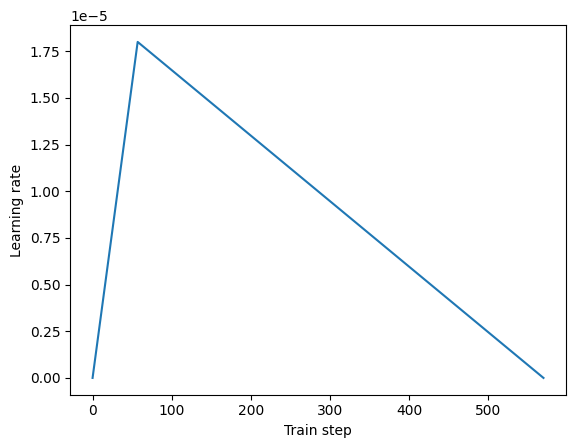

In [61]:
x = tf.linspace(0, num_train_steps, 1001).numpy()
y = [lr(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')

The advantage to using `config` objects is that they don't contain any complicated TensorFlow objects, and can be easily serialized to JSON, and rebuilt. Here's the JSON for the above `tfm.optimization.OptimizationConfig`:

In [62]:
optimization_config = optimization_config.as_dict()
optimization_config

{'optimizer': {'type': 'adam',
  'adam': {'clipnorm': None,
   'clipvalue': None,
   'global_clipnorm': None,
   'name': 'Adam',
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False}},
 'ema': None,
 'learning_rate': {'type': 'polynomial',
  'polynomial': {'name': 'PolynomialDecay',
   'initial_learning_rate': 2e-05,
   'decay_steps': 570,
   'end_learning_rate': 0.0,
   'power': 1.0,
   'cycle': False,
   'offset': 0}},
 'warmup': {'type': 'linear',
  'linear': {'name': 'linear', 'warmup_learning_rate': 0, 'warmup_steps': 57}}}

The `tfm.optimization.optimizer_factory.OptimizerFactory` can just as easily build the optimizer from the JSON dictionary:

In [63]:
fac = tfm.optimization.optimizer_factory.OptimizerFactory(
    tfm.optimization.OptimizationConfig(optimization_config))
lr = fac.build_learning_rate()
optimizer = fac.build_optimizer(lr=lr)